# Normalization
Image normalization can improve model generalization and training speed.
The xrays we have are all grayscale images. Therefore we will be mainly concered with the brightness and contrast of the images.
We'd like to:
 - reduce noise (singal spikes due to black background or white text overlay)
 - increase visibility of details 
 
In this notebook we will test the following methods:
- [Histogram Equalization](https://docs.opencv.org/3.1.0/d5/daf/tutorial_py_histogram_equalization.html)
- Intensity Rescaling / [digital windowing](http://www.sprawls.org/resources/DIGPROCESS/module.htm#13)
  -  dynamically windowing as described by [Guendel et al](https://arxiv.org/abs/1905.06362)
- gaussian smoothing 
- median filtering 
- [Unsharp masking](https://scikit-image.org/docs/dev/auto_examples/filters/plot_unsharp_mask.html) / [Blurred Mask Subtraction](http://www.sprawls.org/resources/DIGPROCESS/module.htm#14)

In [1]:
import os 
#make sure your working directory is the repository root. 
os.chdir("../../../")
os.getcwd()

'C:\\Users\\tsbau\\git\\idp-radio-1'

In [2]:
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimgat
import scipy.ndimage as ndimage
import skimage
from sklearn.preprocessing import normalize
from src.preprocessing.rescaling import scaler
from src.preprocessing.normalizing import normalizer

# Initialization
Loading test image:

In [3]:
dataset_folder = "data/dev_dataset/"
chexpert_folder = dataset_folder + "CheXpert-v1.0-small/"

In [4]:
frontal = cv2.imread(chexpert_folder + 'train/patient00002/study1/view1_frontal.jpg', cv2.IMREAD_GRAYSCALE) 
lateral = cv2.imread(chexpert_folder + 'train/patient00002/study1/view2_lateral.jpg', cv2.IMREAD_GRAYSCALE)

frontal_resized = scaler.Scaler(frontal, 320).resize('LINEAR') * 255
lateral_resized = scaler.Scaler(lateral, 320).resize('LINEAR') * 255
num_bins = 256
grayscale_vlaues = [0,255]

# images need to be of type 'unsigned int 8bit' for cv2.equalizeHist to work
frontal_resized = np.uint8(frontal_resized)
lateral_resized = np.uint8(lateral_resized)

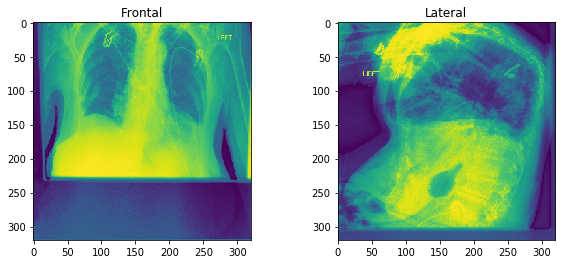

In [5]:
def show_image (img, fig_size = (10, 4)):
    fig, ax = plt.subplots(figsize = fig_size)
    ax.imshow(img)
    plt.show()

def show_images (frontal, lateral, fig_size = (10, 4), alignment="horizontal"):
    if (alignment == "vertical"):
        fig, axs = plt.subplots(nrows=2, figsize = fig_size)
    else:
        fig, axs = plt.subplots(ncols=2, figsize = fig_size)
    axs[0].set_title('Frontal')
    axs[0].imshow(frontal)
    axs[1].set_title('Lateral')
    axs[1].imshow(lateral)
    plt.show()
show_images(frontal_resized, lateral_resized)

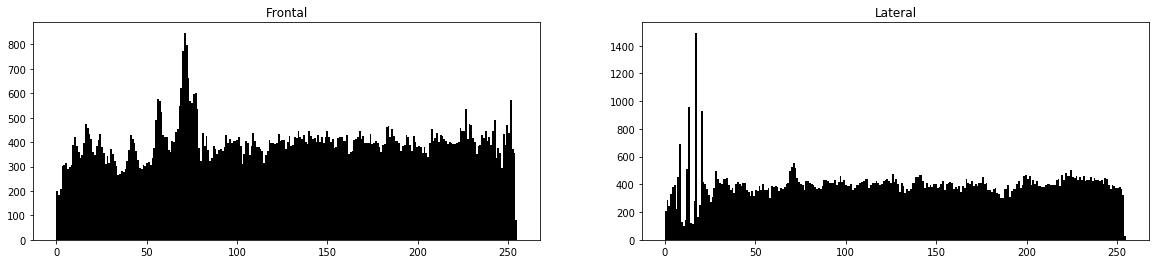

In [6]:
def plot_historgram(frontal, lateral, fig_size = (20, 4)):
    fig, axs = plt.subplots(ncols=2, figsize = fig_size)
    axs[0].set_title('Frontal')
    axs[0].hist(frontal.flatten(),num_bins, grayscale_vlaues, color = 'k')
    axs[1].set_title('Lateral')
    axs[1].hist(lateral.flatten(),num_bins, grayscale_vlaues, color = 'k')
    plt.show()
plot_historgram(frontal_resized, lateral_resized)

# Histogram Equalization
Wikipedia page on [Histogram Equalization](https://en.wikipedia.org/wiki/Histogram_equalization) for mathematical details on implementation

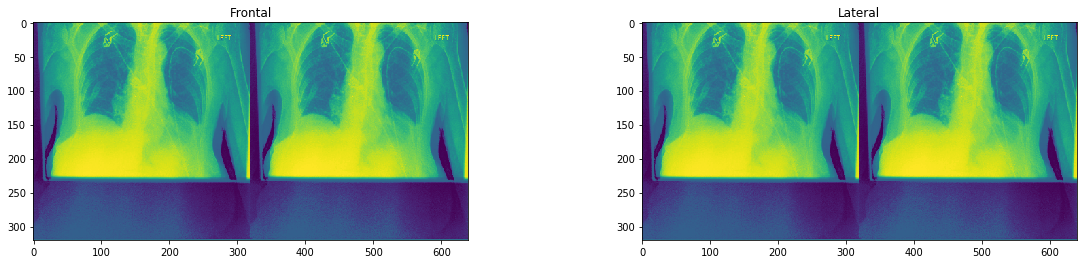

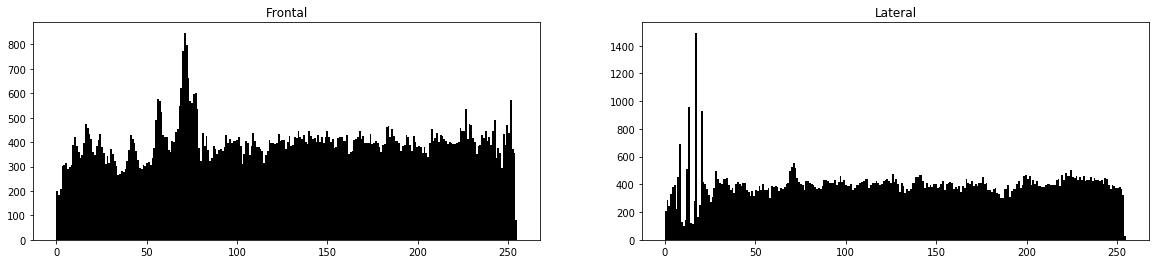

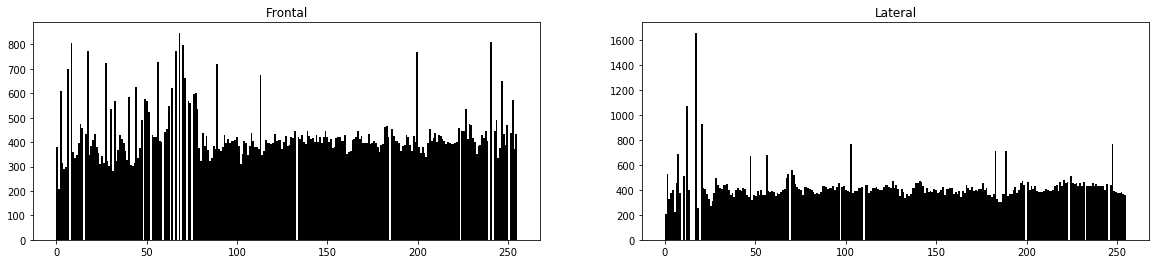

In [7]:
def apply_hist_equalization (img):
    return cv2.equalizeHist(img)


def show_hist_equalization_samples ():
    frontal_equalized_hist = [frontal_resized] + [apply_hist_equalization(frontal_resized)]
    lateral_equalized_hist = [lateral_resized] + [apply_hist_equalization(lateral_resized)]

    show_images(np.hstack(tuple(frontal_equalized_hist)),
                np.hstack(tuple(frontal_equalized_hist)),
                fig_size = (20, 4),)
    plot_historgram(frontal_equalized_hist[0], lateral_equalized_hist[0])
    plot_historgram(frontal_equalized_hist[1], lateral_equalized_hist[1])

show_hist_equalization_samples()

# Windowing / Intensity Rescaling

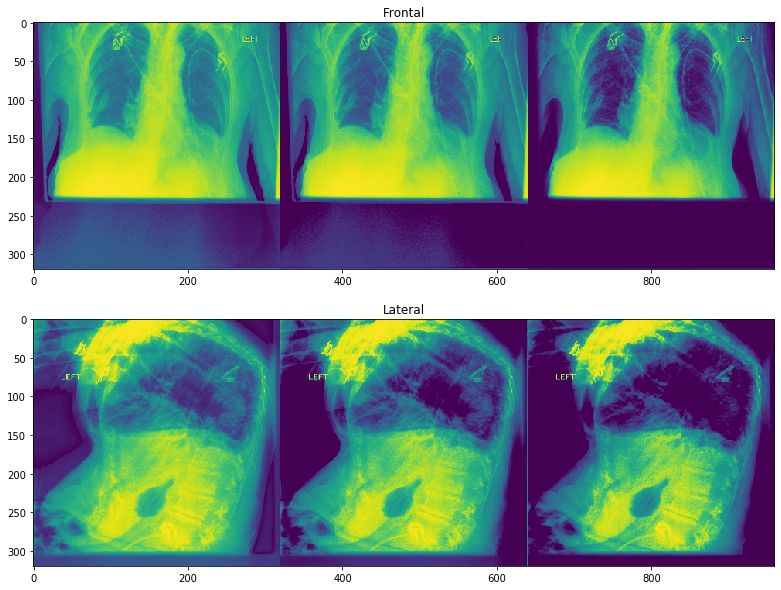

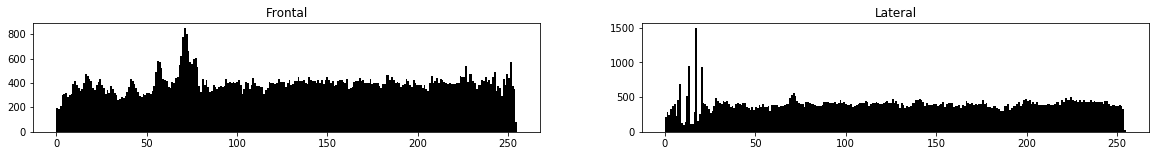

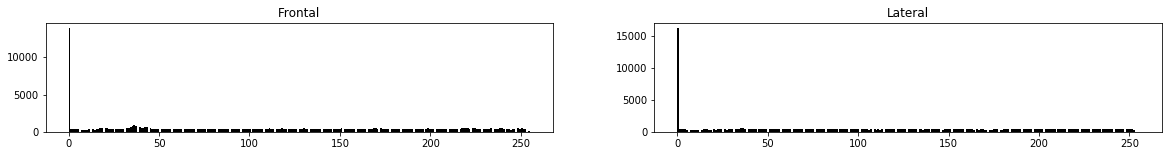

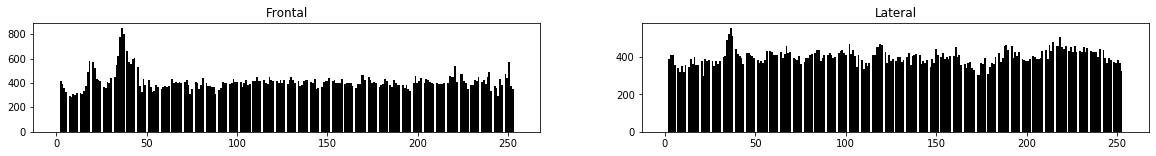

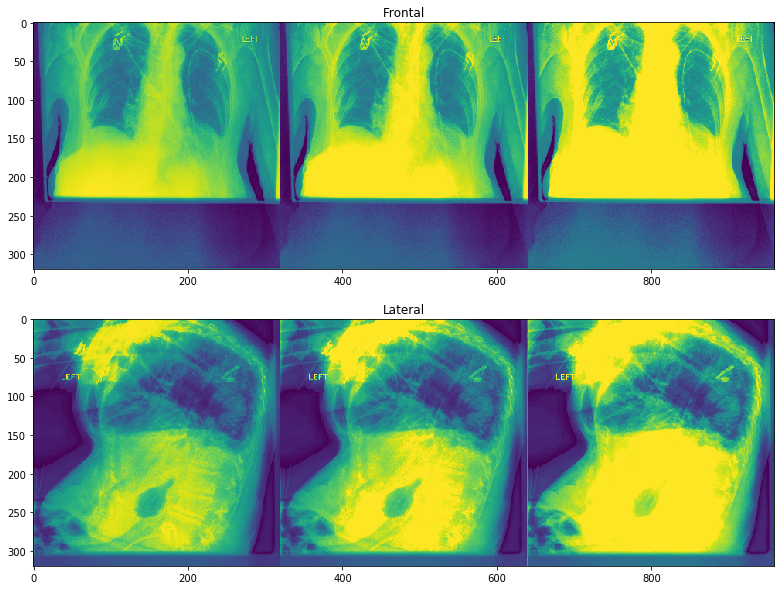

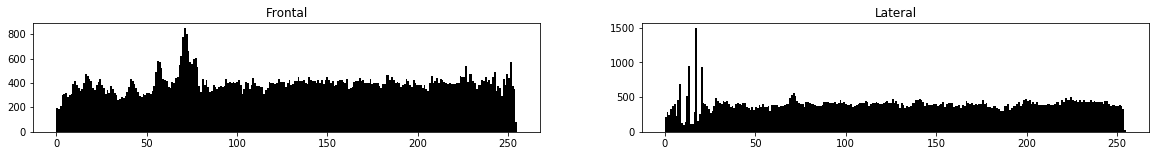

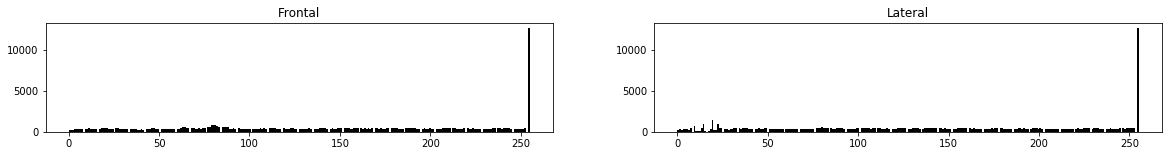

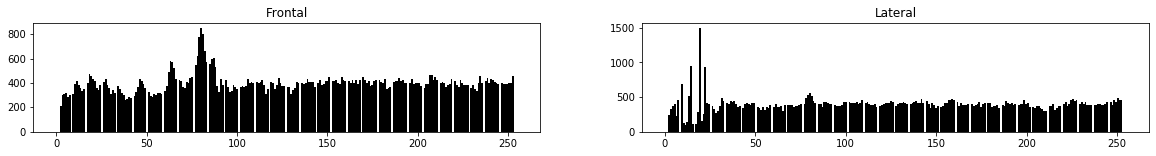

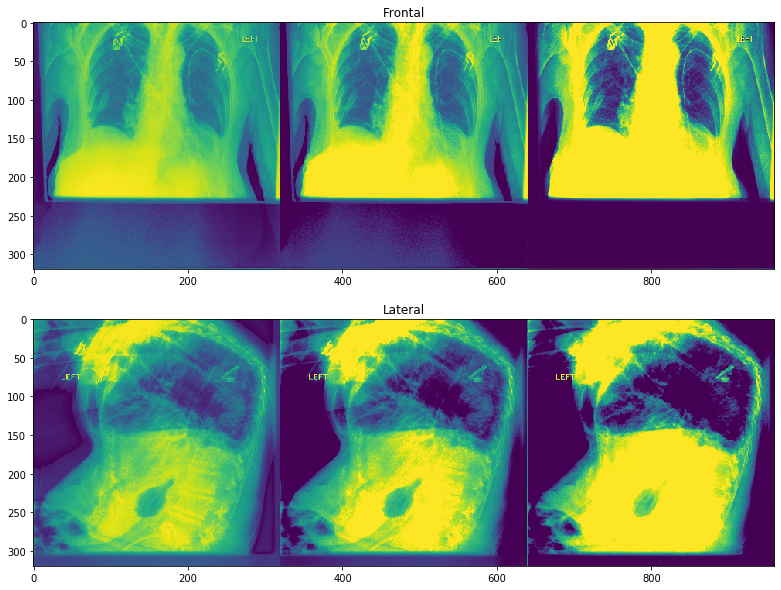

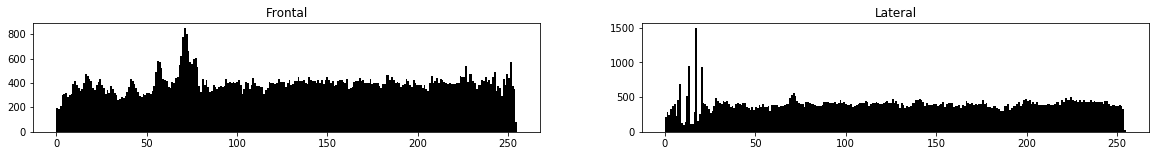

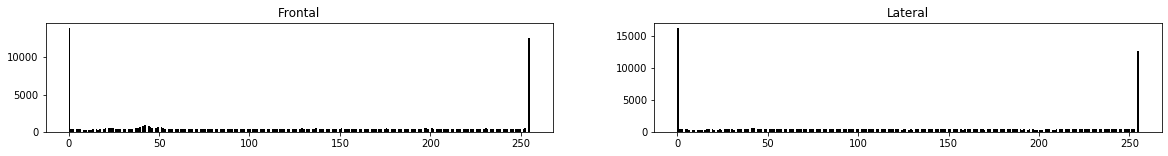

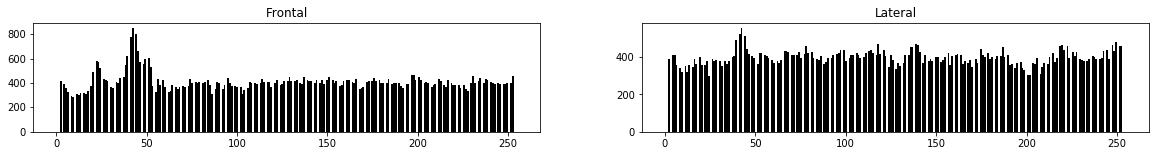

In [8]:
def bound (img, max = 254, min = 1):
    return img[(img < max) & (img > min)]

def apply_windowing (img, window = (40,255)):
    return skimage.exposure.rescale_intensity(img, in_range=window) 


def show_rescaled_samples (bounds):
    frontal_rescaled = [frontal_resized] + [apply_windowing(frontal_resized, window=bound) for bound in bounds]
    lateral_rescaled = [lateral_resized] + [apply_windowing(lateral_resized, window=bound) for bound in bounds]

    show_images(np.hstack(tuple(frontal_rescaled)),
                np.hstack(tuple(lateral_rescaled)),
                fig_size = (20, 10),
                alignment = "vertical")
    plot_historgram(frontal_rescaled[0], lateral_rescaled[0], fig_size = (20, 2))
    plot_historgram((frontal_rescaled[1]), (lateral_rescaled[1]), fig_size = (20, 2))
    plot_historgram(bound(frontal_rescaled[1]), bound(lateral_rescaled[1]), fig_size = (20, 2))

# only increase lower bounds
show_rescaled_samples([(40,255), (80,255)])

# only increase upper bounds
show_rescaled_samples([(0,225), (0,185)])

# increase both lower and upper bounds
show_rescaled_samples([(40,225), (80,185)])

## Gaussian Smoothing

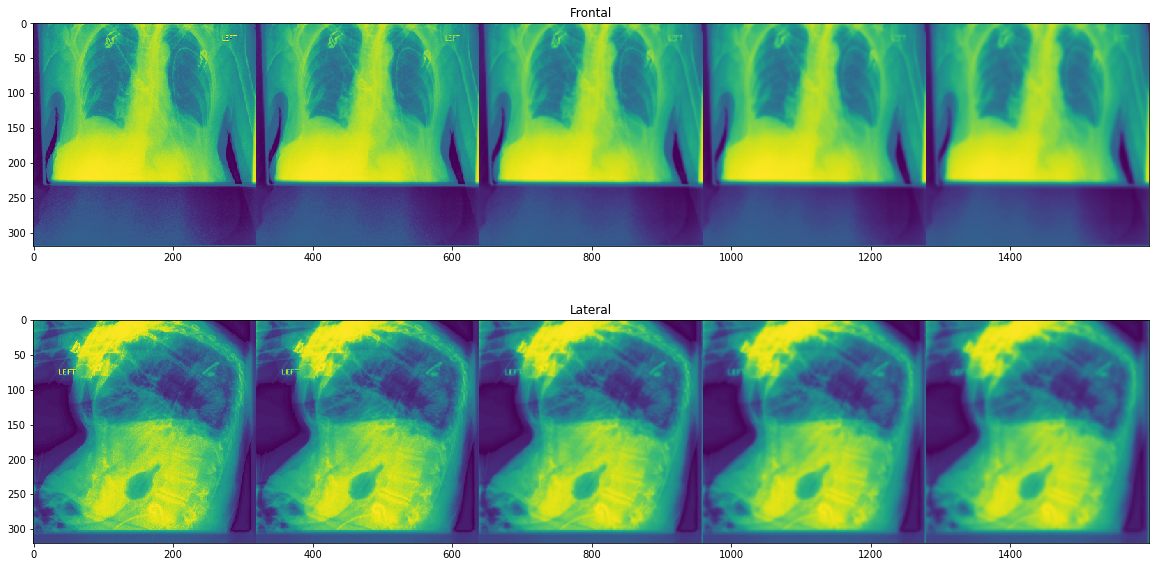

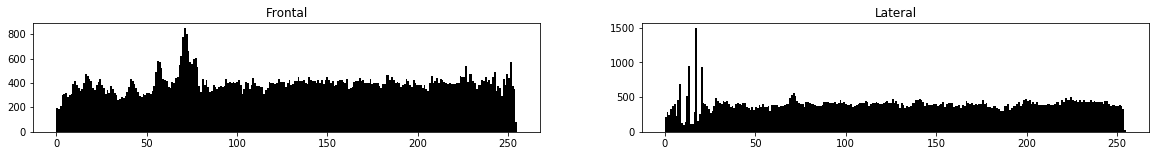

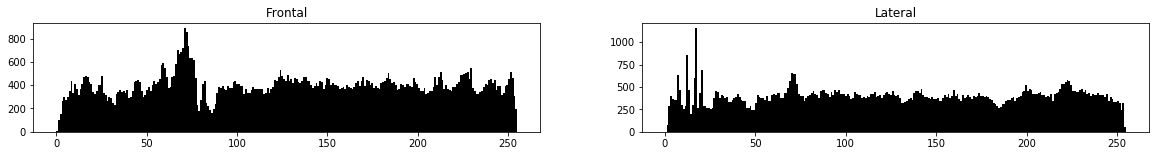

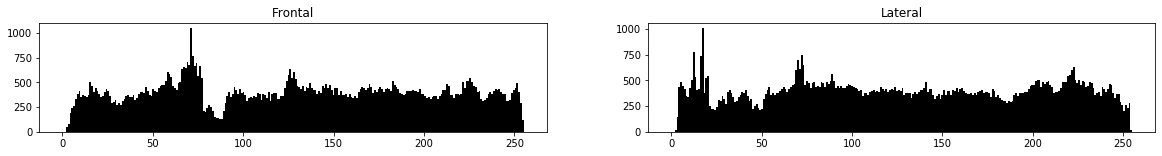

In [9]:
def apply_gaussian_filter (img, sigma = 1):
    return skimage.filters.gaussian(img, sigma) * 255


def show_gaussian_smoothing_samples (stds):
    frontal_samples = [frontal_resized] + [apply_gaussian_filter(frontal_resized, sigma) for sigma in stds]
    lateral_samples = [lateral_resized] + [apply_gaussian_filter(lateral_resized, sigma) for sigma in stds]

    show_images(np.hstack(tuple(frontal_samples)),
                np.hstack(tuple(lateral_samples)),
                fig_size = (20, 10),
                alignment = "vertical")
    plot_historgram(frontal_samples[0], lateral_samples[0], fig_size = (20, 2))
    plot_historgram(frontal_samples[2], lateral_samples[2], fig_size = (20, 2))
    plot_historgram(frontal_samples[-1], lateral_samples[-1], fig_size = (20, 2))

# only increase lower bounds
show_gaussian_smoothing_samples([0.5, 1, 1.5, 2])

# Median Filtering

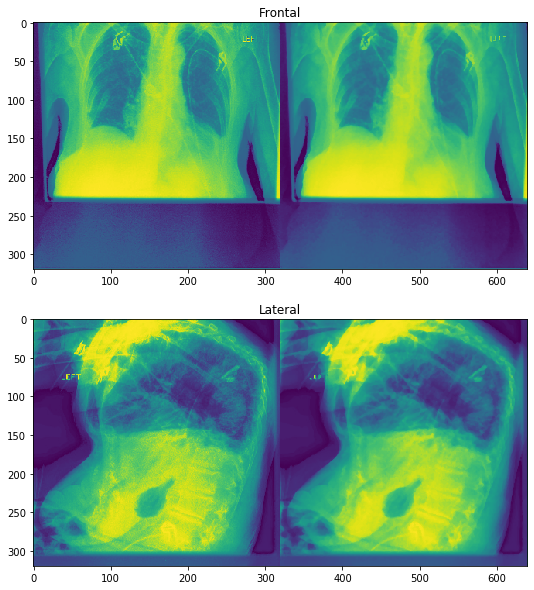

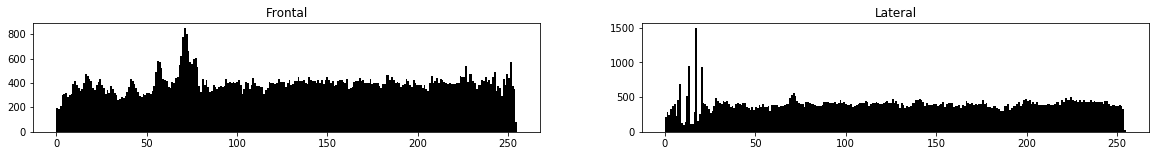

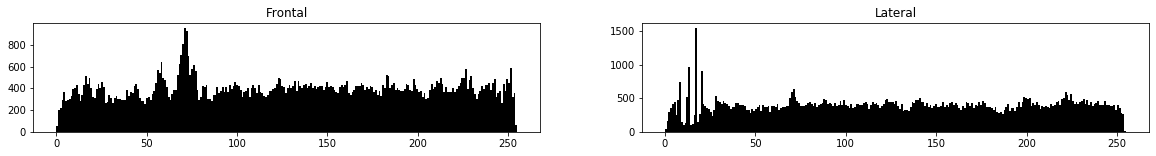

In [10]:
def apply_median_filter (img):
    return skimage.filters.median(img)


def show_median_filter_samples ():
    frontal_samples = [frontal_resized] + [apply_median_filter(frontal_resized)]
    lateral_samples = [lateral_resized] + [apply_median_filter(lateral_resized)]

    show_images(np.hstack(tuple(frontal_samples)),
                np.hstack(tuple(lateral_samples)),
                fig_size = (20, 10),
                alignment = "vertical")
    
    plot_historgram(frontal_samples[0], lateral_samples[0], fig_size = (20, 2))
    plot_historgram(frontal_samples[-1], lateral_samples[-1], fig_size = (20, 2))

# only increase lower bounds
show_median_filter_samples()

# Unsharp masking / Blurred Mask Subtracation
Unsharp masking is a linear image processing technique which sharpens the image. The sharp details are identified as a difference between the original image and its blurred version. These details are then scaled, and added back to the original image:

```enhanced_image = original + amount * (original-blurred)```

The blurring step could use any image filter method, e.g. median filter, but traditionally a gaussian filter is used. The radius parameter in the unsharp masking filter refers to the sigma parameter of the gaussian filter.


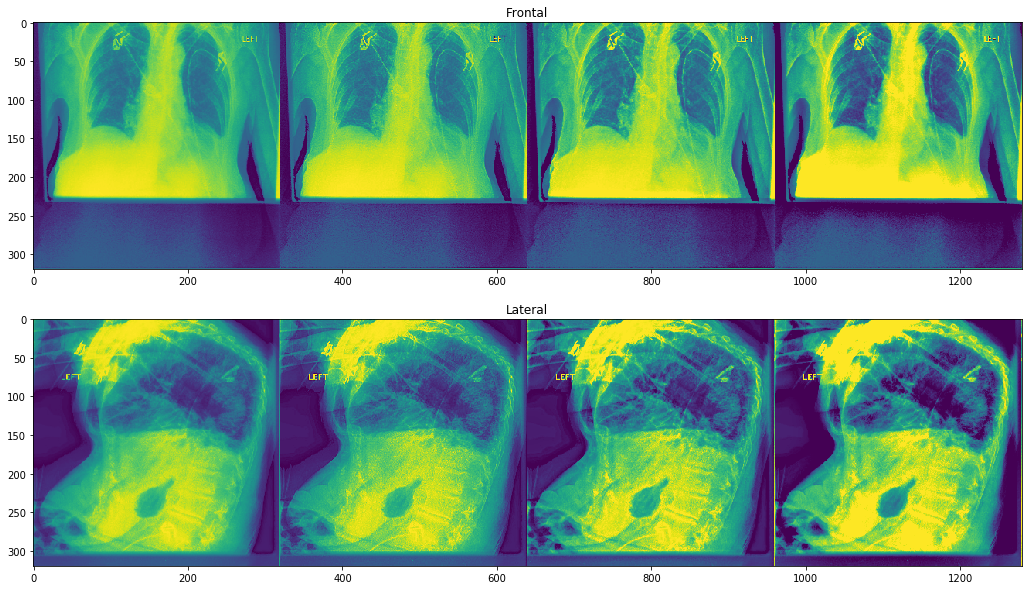

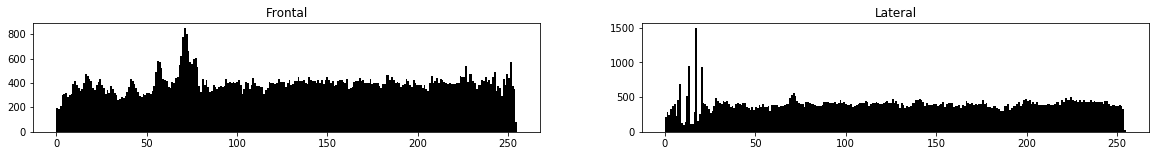

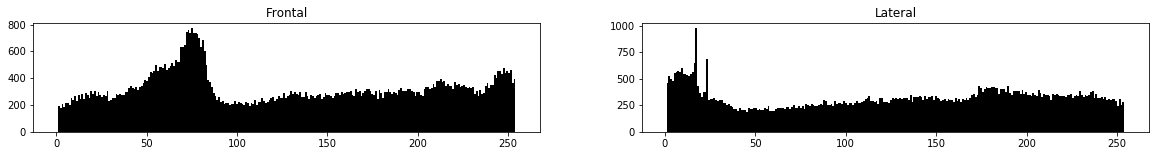

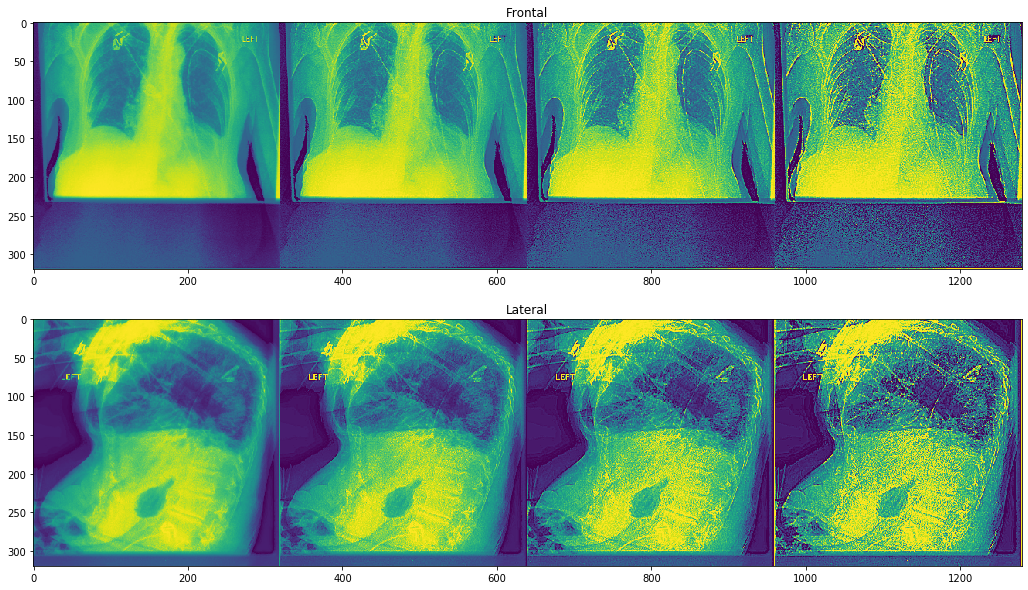

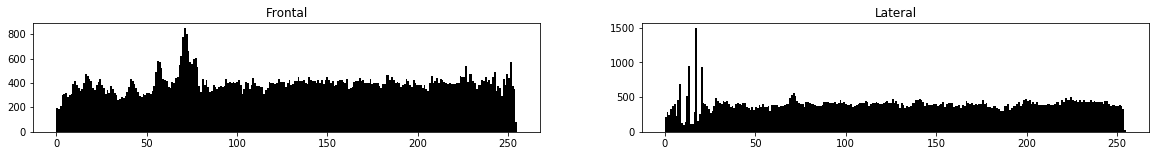

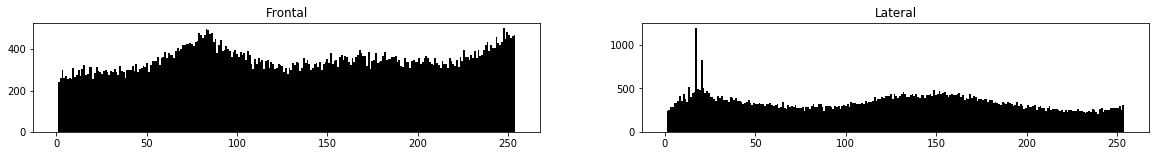

In [11]:
def apply_unsharp_mask (img, radius = 1, amount = 1):
    return skimage.filters.unsharp_mask(img, radius=radius, amount=amount)* 255

def show_blurred_mask_subtraction_samples (args):
    frontal_samples = [frontal_resized] + [apply_unsharp_mask(frontal_resized, radius=r, amount=n) for (r, n) in args]
    lateral_samples = [lateral_resized] + [apply_unsharp_mask(lateral_resized, radius=r, amount=n) for (r, n) in args]

    show_images(np.hstack(tuple(frontal_samples)),
                np.hstack(tuple(lateral_samples)),
                fig_size = (20, 10),
                alignment = "vertical")
    
    hist_mask = range(10,234)
    plot_historgram(frontal_samples[0], lateral_samples[0], fig_size = (20, 2))
    plot_historgram(bound(frontal_samples[-1]), bound(lateral_samples[-1]), fig_size = (20, 2))

# only increase lower bounds
show_blurred_mask_subtraction_samples([(1, 1), (5, 1), (20, 1)])
show_blurred_mask_subtraction_samples([(1, 2), (1, 5), (1, 10)])

 # Playground
    
Testing and Combining different filters:

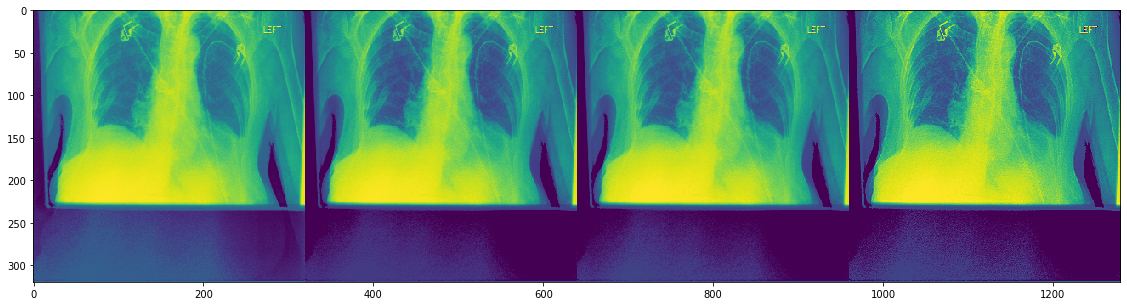

In [23]:
output = [frontal_resized]
norm = normalizer.Normalizer(frontal_resized)

norm.apply_windowing()
output.append(norm.get_img())

norm.apply_hist_equalization()
output.append(norm.get_img())

norm.apply_unsharp_mask()
output.append(norm.get_img())

show_image(np.hstack(tuple(output)), fig_size = (20, 5))

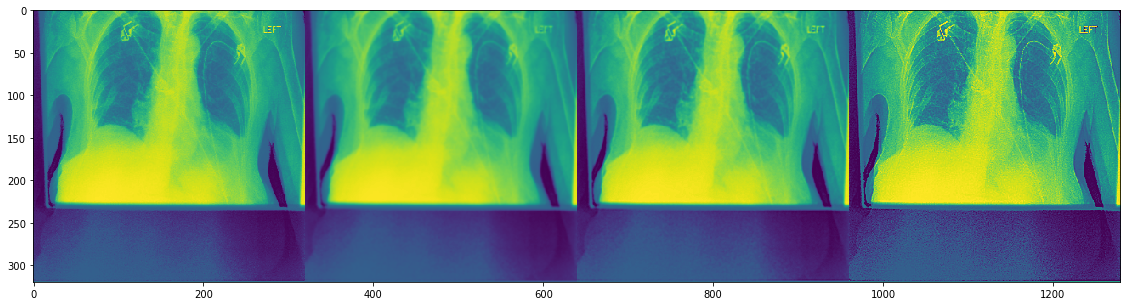

In [39]:
output = [frontal_resized]
norm = normalizer.Normalizer(frontal_resized)


norm.apply_gaussian_filter(sigma=1)
output.append(norm.get_img())

norm.apply_unsharp_mask(radius = 1, amount = 2)
output.append(norm.get_img())

norm.reset().apply_unsharp_mask(radius = 1, amount = 2)
output.append(norm.get_img())

show_image(np.hstack(tuple(output)), fig_size = (20, 5))

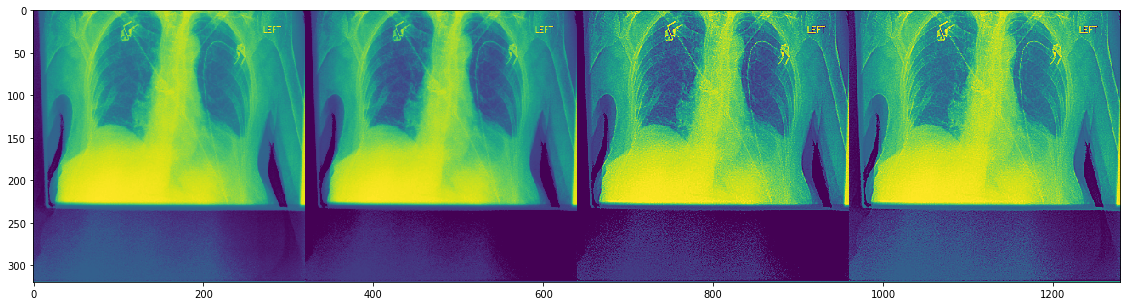

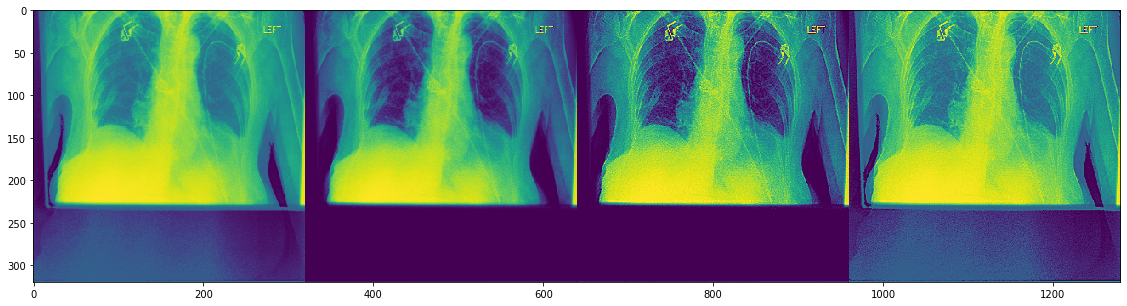

In [44]:
output = [frontal_resized]
norm = normalizer.Normalizer(frontal_resized)



norm.apply_windowing(window = (40,255))
output.append(norm.get_img())

norm.apply_unsharp_mask(radius = 1, amount = 2)
output.append(norm.get_img())

norm.reset().apply_unsharp_mask(radius = 1, amount = 2)
output.append(norm.get_img())
show_image(np.hstack(tuple(output)), fig_size = (20, 5))

output = [frontal_resized]
norm.reset()
norm.apply_windowing( window = (80,255))
output.append(norm.get_img())

norm.apply_unsharp_mask(radius = 1, amount = 2)
output.append(norm.get_img())

norm.reset().apply_unsharp_mask(radius = 1, amount = 2)
output.append(norm.get_img())
show_image(np.hstack(tuple(output)), fig_size = (20, 5))
